In [32]:
import tensorflow as tf

# create a NN using SGD as our optimization function and MSE as the loss function
# using the params we found from grid search
def create_model(activation_function_hidden='relu', 
                 activation_function_output='sigmoid', 
                 hidden_units=2, 
                 hidden_layers=1, 
                 regularizer = tf.keras.regularizers.l2, 
                 reg_param = 0.01, 
                 momentum = 0.01, 
                 learning_rate = 0.001): 
    # TODO: implement our nueral network structure using SGD as the optimization technique (Martin)

    # REMOVE LATER: the code below is only for hyper parameter tuning. Eventually we want to pick 1 set of hyper parameters to use and use those for our final script.
    model = tf.keras.Sequential()
    # Input layer and first hidden layer
    model.add(tf.keras.layers.Dense(hidden_units, input_dim=train_data.shape[1], activation=activation_function_hidden, 
                    kernel_regularizer = regularizer(reg_param)))
    
    # Additional hidden layers if specified
    for _ in range(hidden_layers - 1):
        model.add(tf.keras.layers.Dense(hidden_units, activation=activation_function_hidden, 
                        kernel_regularizer=regularizer(reg_param)))
    # Output layer
    model.add(tf.keras.layers.Dense(1, activation=activation_function_output))
    
    # compile the model using SGD as the optimizer and MSE as our loss function
    optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=momentum)
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model


In [33]:
import glob
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import joblib

model = joblib.load('../elderly_activity_model.gz')

def predict(df):
    predictions = model.predict(df.drop(columns=['activity']))
    df_pred = df.copy()
    df_pred['activity'] = (predictions >= 0.1792).astype(int)
    return df_pred

def calc_and_add_accel(dataframe):
    acceleration = []
    for i in range(dataframe.shape[0]):
        fa = dataframe['frontal accel'][i]
        la = dataframe['lateral accel'][i]
        va = dataframe['vertical accel'][i]

        accel_vector = np.sqrt(fa**2 + la**2 + va**2)
        acceleration.append(accel_vector)

    dataframe['acceleration'] = acceleration
    return dataframe

def read_patient_data(file, gender, room):
    df = pd.read_csv(file, header=None)
    df.columns = [
        'time',
        'frontal accel',
        'vertical accel',
        'lateral accel',
        'antenna id',
        'rssi',
        'phase',
        'frequency',
        'activity',
    ]
    df['gender'] = gender
    df['room'] = room
    calc_and_add_accel(df)
    df.replace({'activity': {1: 0, 2: 0, 3: 0, 4: 1}}, inplace=True)
    return df

In [34]:

df_list = []

for file in sorted(glob.glob('../S1_Dataset/d1p*F')):
    df = read_patient_data(file, 0, 1)
    df_list.append(df)

for file in sorted(glob.glob('../S1_Dataset/d1p*M')):
    df = read_patient_data(file, 1, 1)
    df_list.append(df)

for file in sorted(glob.glob('../S2_Dataset/d2p*F')):
    df = read_patient_data(file, 0, 2)
    df_list.append(df)

for file in sorted(glob.glob('../S2_Dataset/d2p*M')):
    df = read_patient_data(file, 1, 2)
    df_list.append(df)

df = pd.concat(df_list, axis=0, ignore_index=True)

In [35]:
import matplotlib.patches as mpatches

colors = {
    0: 'C0',
    1: 'C1',
}

legend = [
    mpatches.Patch(color='C0', label='inactive'),
    mpatches.Patch(color='C1', label='active'),
]

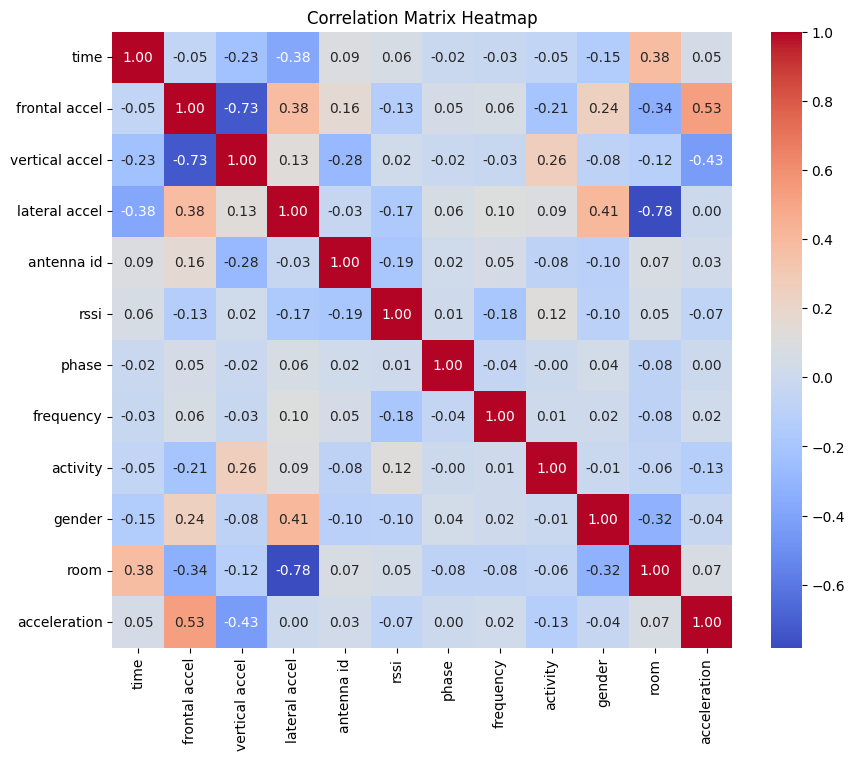

In [36]:
# Calculate correlation matrix
correlation_matrix = df.corr()

# Visualize correlation matrix using heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix,
            annot=True,
            cmap='coolwarm',
            fmt='.2f')
plt.title('Correlation Matrix Heatmap')
plt.show()

In [37]:
def plot3D(df, legend=legend, lim3d=None):
    xname = 'frontal accel'
    yname = 'lateral accel'
    zname = 'vertical accel'
    x = df[xname]
    y = df[yname]
    z = df[zname]
    fig = plt.figure(figsize=(6, 6))
    ax = plt.axes(projection='3d')
    ax.scatter3D(x, y, z, c=df['activity'].map(colors))
    # ax.set_title(f"activity vs acceleration")
    ax.set_xlabel(xname)
    ax.set_ylabel(yname)
    ax.set_zlabel(zname)
    ax.zaxis.labelpad = -0.7
    if legend != None:
        ax.legend(handles=legend)
    if lim3d != None:
        xlim3d, ylim3d, zlim3d = lim3d
        ax.axes.set_xlim3d(*xlim3d)
        ax.axes.set_ylim3d(*ylim3d)
        ax.axes.set_zlim3d(*zlim3d)
    plt.tight_layout()
    plt.show()
    return ax.axes.get_xlim3d(), ax.axes.get_ylim3d(), ax.axes.get_zlim3d()

In [38]:
def plot_accel_vs_accel(df, legend=legend):
    return

    plt.figure(figsize=(12, 12))

    xname = 'vertical accel'
    yname = 'frontal accel'
    x = df[xname]
    y = df[yname]
    plt.subplot(3, 3, 1)
    plt.scatter(x, y, c=df['activity'].map(colors))
    # plt.title(f"{yname} vs {xname}")
    plt.xlabel(xname)
    plt.ylabel(yname)
    if legend != None:
        plt.legend(handles=legend, fontsize=6)
    plt.axhline(y=0, color='gray', linestyle='--')
    plt.axvline(x=0, color='gray', linestyle='--')

    xname = 'lateral accel'
    yname = 'frontal accel'
    x = df[xname]
    y = df[yname]
    plt.subplot(3, 3, 2)
    plt.scatter(x, y, c=df['activity'].map(colors))
    # plt.title(f"{yname} vs {xname}")
    plt.xlabel(xname)
    plt.ylabel(yname)
    if legend != None:
        plt.legend(handles=legend, fontsize=6)
    plt.axhline(y=0, color='gray', linestyle='--')
    plt.axvline(x=0, color='gray', linestyle='--')

    xname = 'lateral accel'
    yname = 'vertical accel'
    x = df[xname]
    y = df[yname]
    plt.subplot(3, 3, 3)
    plt.scatter(x, y, c=df['activity'].map(colors))
    # plt.title(f"{yname} vs {xname}")
    plt.xlabel(xname)
    plt.ylabel(yname)
    if legend != None:
        plt.legend(handles=legend, fontsize=6)
    plt.axhline(y=0, color='gray', linestyle='--')
    plt.axvline(x=0, color='gray', linestyle='--')

    plt.tight_layout()
    plt.show()

In [39]:
df

,time,frontal accel,vertical accel,lateral accel,antenna id,rssi,phase,frequency,activity,gender,room,acceleration
0,0.00,0.51826,0.89339,0.134560,4,-56.5,5.83680,921.75,0,0,1,1.041559
1,0.25,0.51826,0.89339,0.134560,3,-68.0,4.84120,925.75,0,0,1,1.041559
2,0.75,0.51826,0.89339,0.134560,4,-55.5,3.64170,924.25,0,0,1,1.041559
3,1.25,0.51826,0.89339,0.134560,3,-57.5,1.77790,924.75,0,0,1,1.041559
4,1.75,0.51826,0.89339,0.134560,4,-61.5,0.24083,922.75,0,0,1,1.041559
...,...,...,...,...,...,...,...,...,...,...,...,...
75123,532.00,0.57689,0.88191,0.134560,3,-62.5,3.76290,922.75,0,1,2,1.062391
75124,532.25,0.57689,0.88191,0.134560,2,-63.5,5.60210,924.75,0,1,2,1.062391
75125,533.50,0.35411,0.96229,0.088944,1,-65.0,0.98175,923.75,0,1,2,1.029226
75126,533.75,0.35411,0.96229,0.088944,3,-60.0,1.46030,922.25,0,1,2,1.029226


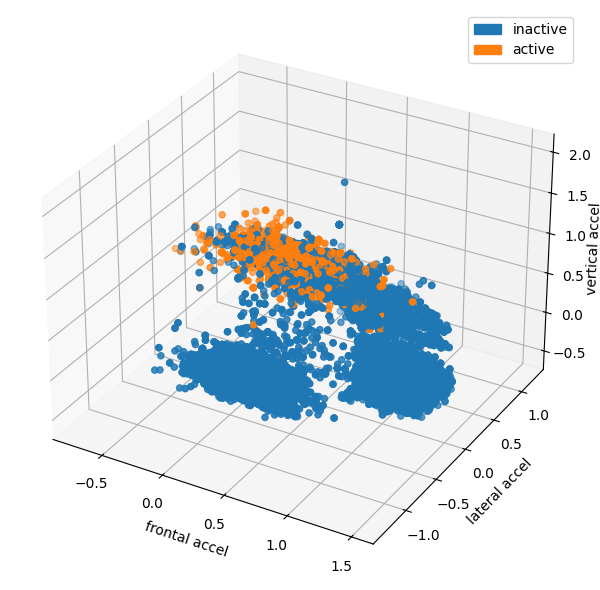

In [40]:
lim3d = plot3D(df)
plot_accel_vs_accel(df)

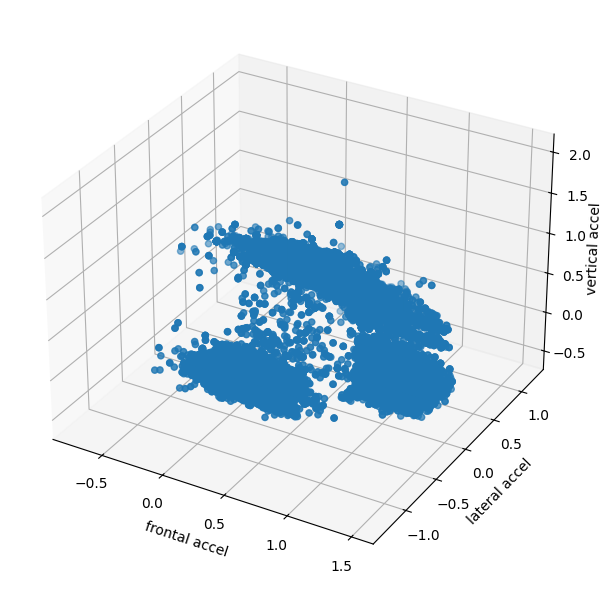

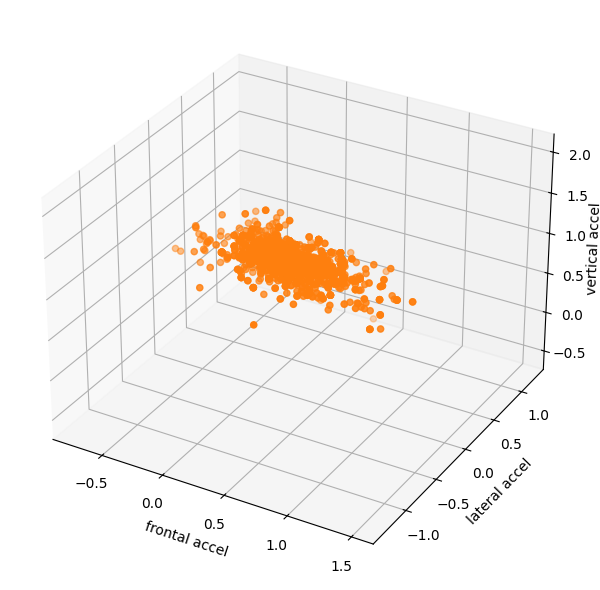

In [41]:
plot3D(df[df['activity'] == 0], legend=None, lim3d=lim3d)
plot_accel_vs_accel(df[df['activity'] == 0], legend=None)
plot3D(df[df['activity'] == 1], legend=None, lim3d=lim3d)
plot_accel_vs_accel(df[df['activity'] == 1], legend=None)

In [42]:
import joblib
model = joblib.load('../elderly_activity_model.gz')
df_pred = df.drop(columns=['activity'])
predictions = (model.predict(df_pred) >= 0.1792).astype(int)
df_pred.insert(len(df_pred.columns) - 3, 'activity', predictions)
df_pred

1382/2348 [================>.............] - ETA: 0s

2348/2348 [==============================] - 1s 593us/step


,time,frontal accel,vertical accel,lateral accel,antenna id,rssi,phase,frequency,activity,gender,room,acceleration
0,0.00,0.51826,0.89339,0.134560,4,-56.5,5.83680,921.75,1,0,1,1.041559
1,0.25,0.51826,0.89339,0.134560,3,-68.0,4.84120,925.75,0,0,1,1.041559
2,0.75,0.51826,0.89339,0.134560,4,-55.5,3.64170,924.25,1,0,1,1.041559
3,1.25,0.51826,0.89339,0.134560,3,-57.5,1.77790,924.75,1,0,1,1.041559
4,1.75,0.51826,0.89339,0.134560,4,-61.5,0.24083,922.75,1,0,1,1.041559
...,...,...,...,...,...,...,...,...,...,...,...,...
75123,532.00,0.57689,0.88191,0.134560,3,-62.5,3.76290,922.75,1,1,2,1.062391
75124,532.25,0.57689,0.88191,0.134560,2,-63.5,5.60210,924.75,1,1,2,1.062391
75125,533.50,0.35411,0.96229,0.088944,1,-65.0,0.98175,923.75,1,1,2,1.029226
75126,533.75,0.35411,0.96229,0.088944,3,-60.0,1.46030,922.25,1,1,2,1.029226


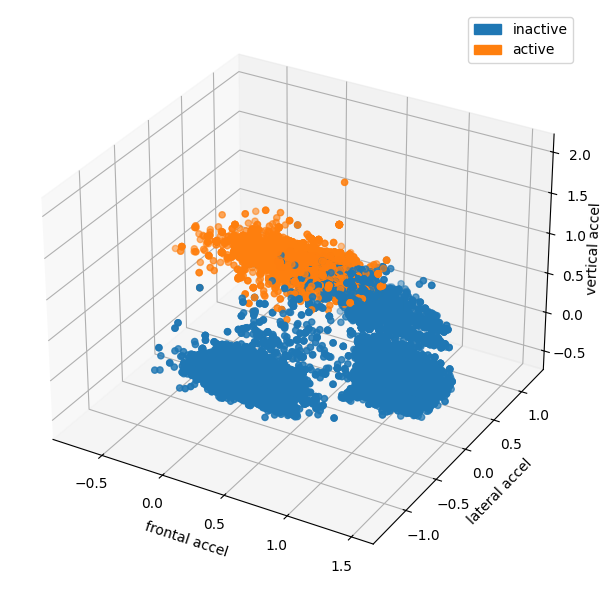

In [43]:
plot3D(df_pred, lim3d=lim3d)
plot_accel_vs_accel(df_pred)

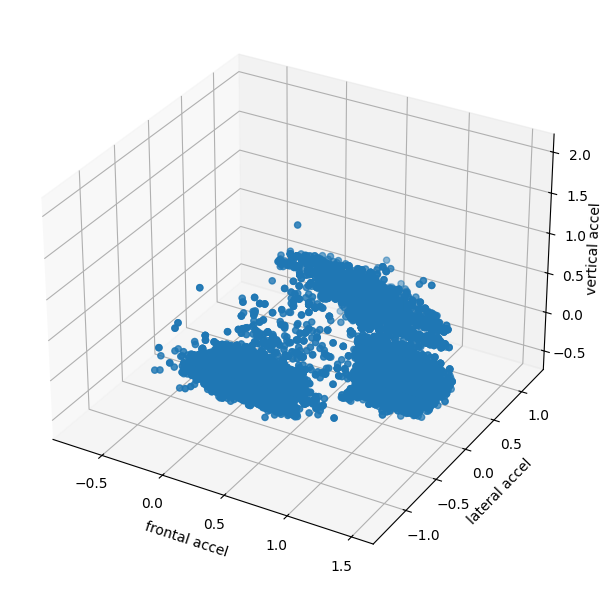

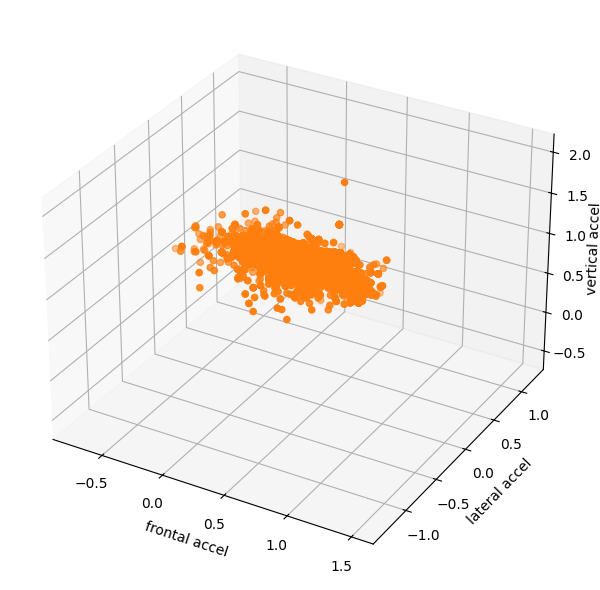

In [44]:
plot3D(df_pred[df_pred['activity'] == 0], legend=None, lim3d=lim3d)
plot_accel_vs_accel(df_pred[df_pred['activity'] == 0], legend=None)
plot3D(df_pred[df_pred['activity'] == 1], legend=None, lim3d=lim3d)
plot_accel_vs_accel(df_pred[df_pred['activity'] == 1], legend=None)

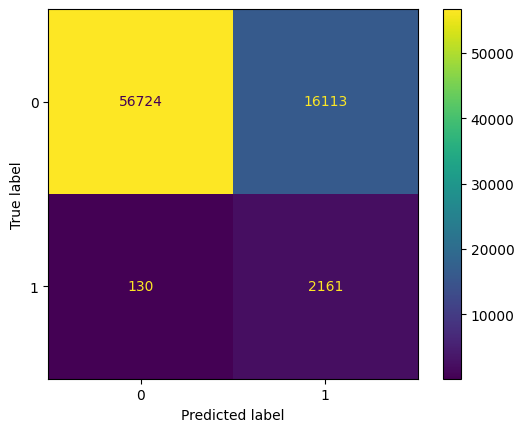

In [45]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(df['activity'], df_pred['activity'])
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

13/13 [==============================] - 0s 696us/step
../S1_Dataset/d1p01M


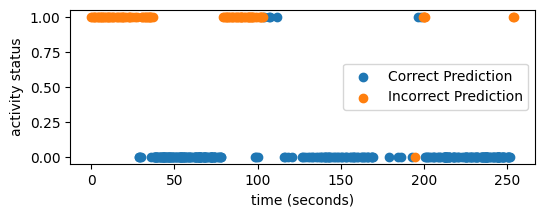

9/9 [==============================] - 0s 694us/step
../S1_Dataset/d1p02M


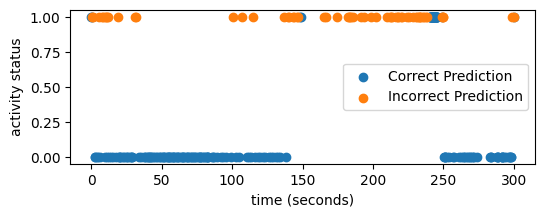

11/11 [==============================] - 0s 674us/step
../S1_Dataset/d1p03M


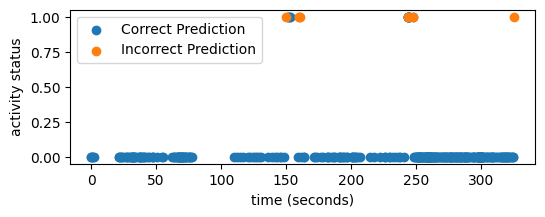

17/17 [==============================] - 0s 702us/step
../S1_Dataset/d1p04M


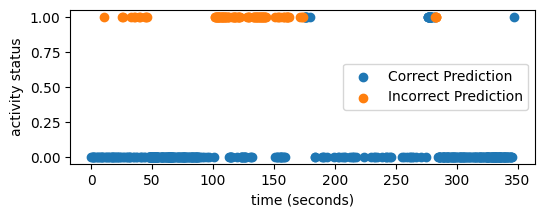

16/16 [==============================] - 0s 637us/step
../S1_Dataset/d1p05M


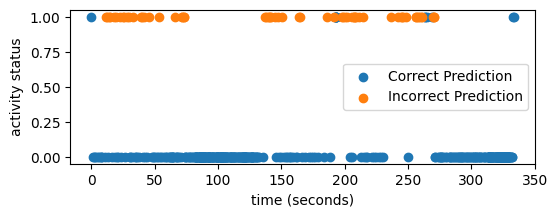

22/22 [==============================] - 0s 659us/step
../S1_Dataset/d1p06M


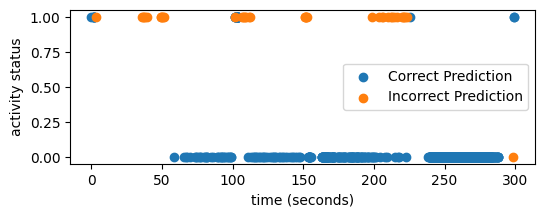

8/8 [==============================] - 0s 712us/step
../S1_Dataset/d1p07M


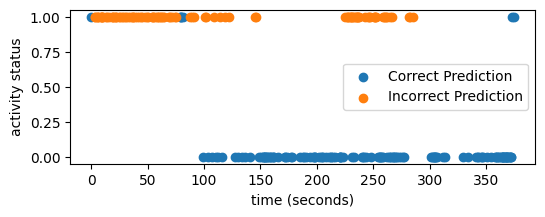

3/3 [==============================] - 0s 1ms/step
../S1_Dataset/d1p08F


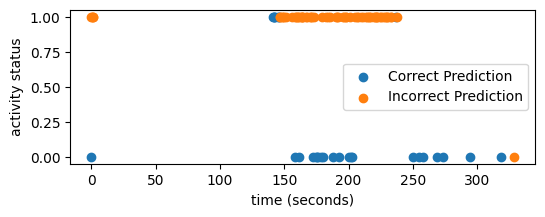

6/6 [==============================] - 0s 764us/step
../S1_Dataset/d1p09F


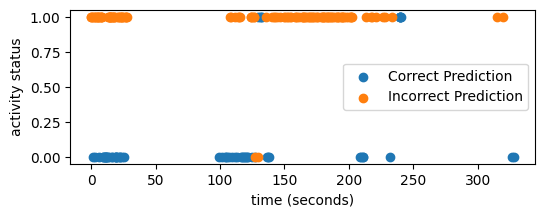

2/2 [==============================] - 0s 2ms/step
../S1_Dataset/d1p10F


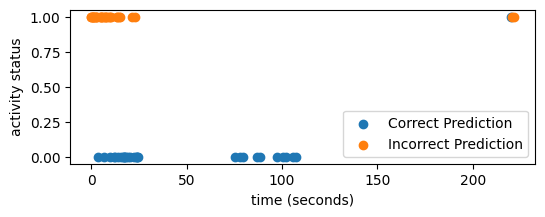

6/6 [==============================] - 0s 798us/step
../S1_Dataset/d1p11F


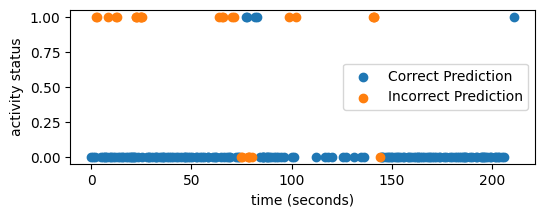

13/13 [==============================] - 0s 656us/step
../S1_Dataset/d1p12F


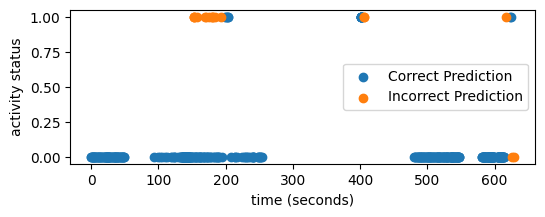

7/7 [==============================] - 0s 733us/step
../S1_Dataset/d1p13F


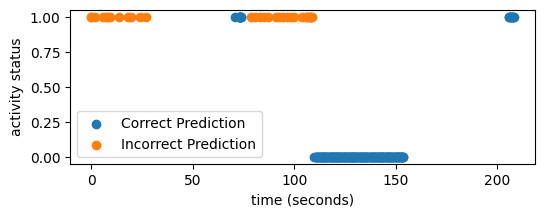

7/7 [==============================] - 0s 800us/step
../S1_Dataset/d1p14F


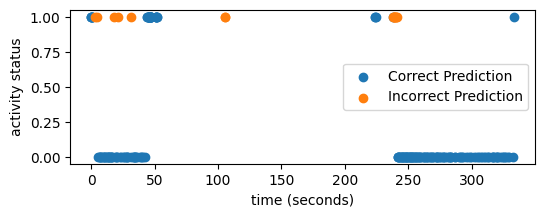

5/5 [==============================] - 0s 789us/step
../S1_Dataset/d1p15F


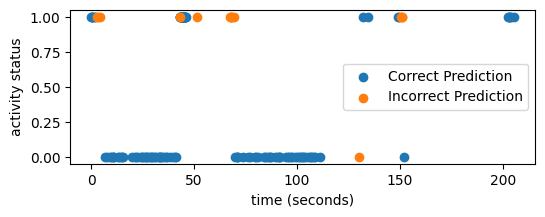

11/11 [==============================] - 0s 690us/step
../S1_Dataset/d1p16F


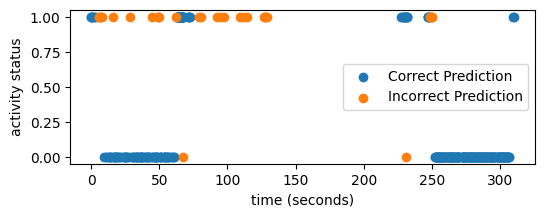

9/9 [==============================] - 0s 718us/step
../S1_Dataset/d1p17F


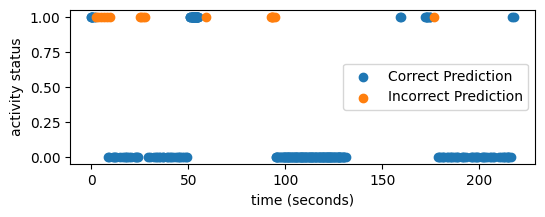

9/9 [==============================] - 0s 724us/step
../S1_Dataset/d1p18F


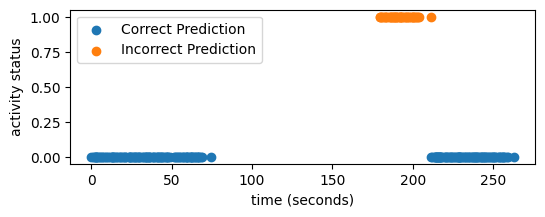

24/24 [==============================] - 0s 626us/step
../S1_Dataset/d1p19F


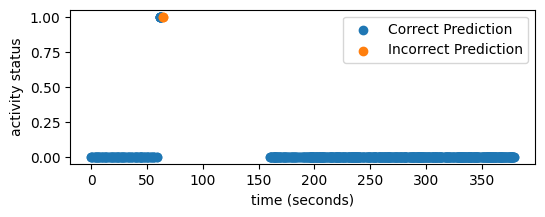

4/4 [==============================] - 0s 930us/step
../S1_Dataset/d1p20F


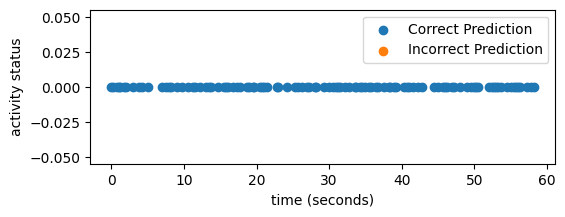

In [48]:
def plot_pred_over_time(df):
    df_pred = predict(df)
    differences = df.compare(df_pred)
    indexes = [index for index, _ in differences.iterrows()]
    df_correct = df.drop(indexes)
    df_incorrect = df_pred.iloc[indexes]
    print(file)
    plt.figure(figsize=(6, 2))
    plt.scatter(df_correct['time'], df_correct['activity'], label='Correct Prediction')
    plt.scatter(df_incorrect['time'], df_incorrect['activity'], label='Incorrect Prediction')
    plt.xlabel('time (seconds)')
    plt.ylabel('activity status')
    plt.legend()
    plt.show()

for file in sorted(glob.glob('../S*_Dataset/d*p*'))[0:20]:
    plot_pred_over_time(read_patient_data(file, 0, 1))

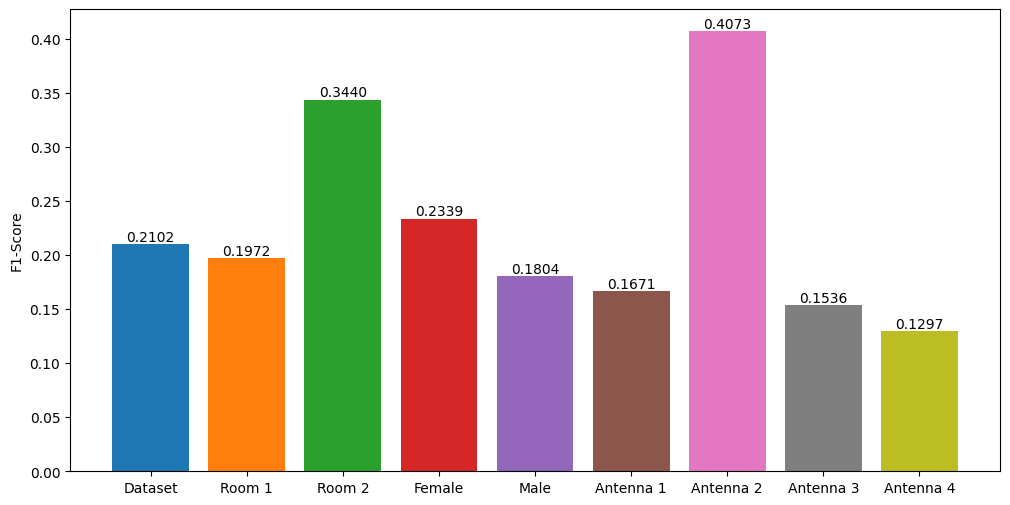

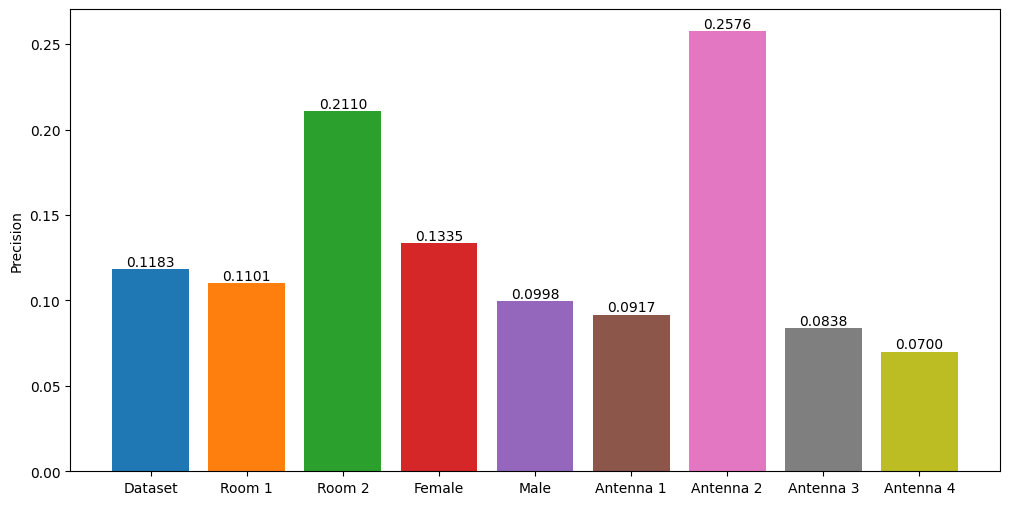

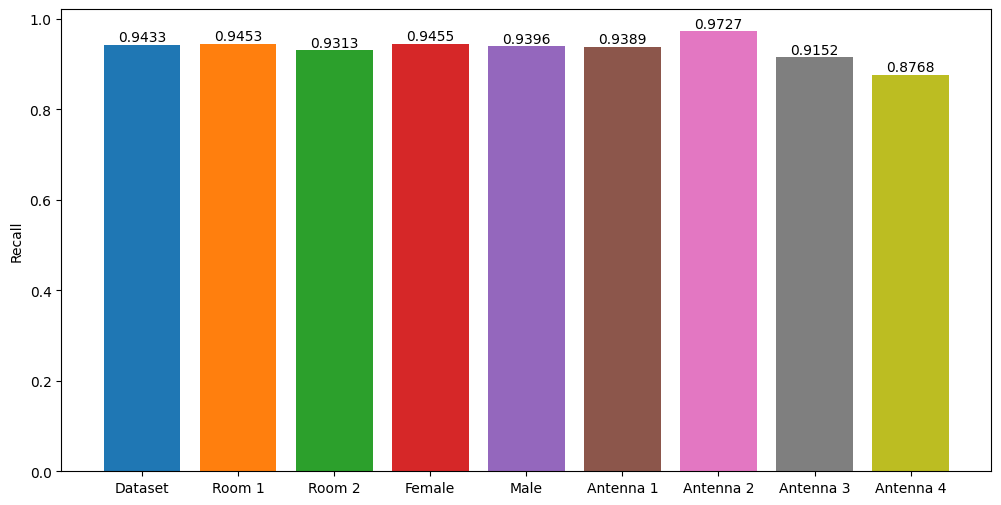

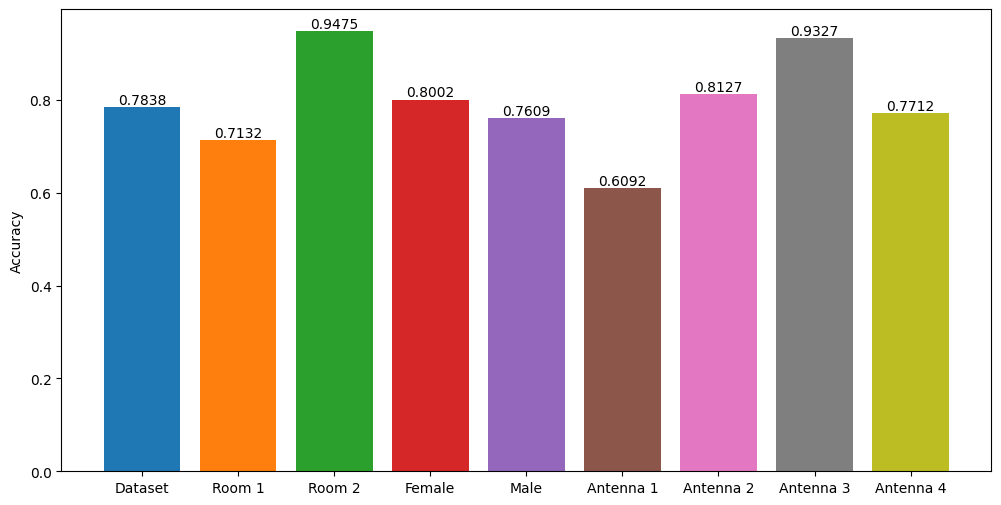

In [126]:
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score

description_history = []
f1_history = []
precision_history = []
recall_history = []
accuracy_history = []
colors = []

def add_eval_metrics(description, df, df_pred):
    y_true = df['activity']
    y_pred = df_pred['activity']

    f1 = f1_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    accuracy = accuracy_score(y_true, y_pred)

    description_history.append(description)
    f1_history.append(f1)
    precision_history.append(precision)
    recall_history.append(recall)
    accuracy_history.append(accuracy)
    colors.append(f'C{len(colors)}')

add_eval_metrics('Dataset', df, df_pred)
add_eval_metrics('Room 1', *(x[x['room'] == 1] for x in (df, df_pred)))
add_eval_metrics('Room 2', *(x[x['room'] == 2] for x in (df, df_pred)))
add_eval_metrics('Female', *(x[x['gender'] == 0] for x in (df, df_pred)))
add_eval_metrics('Male', *(x[x['gender'] == 1] for x in (df, df_pred)))
for id in [1,2,3,4]:
    add_eval_metrics(f'Antenna {id}', *(x[x['antenna id'] == id] for x in (df, df_pred)))

for ylabel, history in zip(
    ('F1-Score', 'Precision', 'Recall', 'Accuracy'),
    (f1_history, precision_history, recall_history, accuracy_history)
):
    fig, ax = plt.subplots(figsize=(12, 6))
    bars = ax.bar(description_history, history, color=colors)
    ax.bar_label(bars, [f'{val:.4f}' for val in history])
    ax.set_ylabel(ylabel)
    plt.show()